In [1]:
from randomwave import *
from scipy.io import savemat
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import pyvista as pv
from tqdm import tqdm, trange

In [2]:
#### Meshgrid ####
n_grid = 50
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

#### Wave vector distribution ####
k_z = 0.01
kappa = 64 #---------> kappa
alpha = 0


#### Generate randomwave ####
scale = 5
k_mean = np.array([0,0,scale])*np.pi # lamellar perpendicular to z axis 
k_var  = (np.array([0,0,k_z*scale/20])*np.pi)**2
k_cov  = np.diagflat(k_var)

rho = sample_wave_MO(r_grid,k_mean,k_cov,n_wave = 64,kappa = kappa)


## Generate isosurface mesh

In [3]:
verts, faces, normals, values = measure.marching_cubes(rho, 0)
# Compute face areas
face_areas = measure.mesh_surface_area(verts, faces)
facet_areas = np.linalg.norm(np.cross(verts[faces[:, 1]] - verts[faces[:, 0]], verts[faces[:, 2]] - verts[faces[:, 0]]), axis=1) / 2
facet_areas.shape

grid = pv.StructuredGrid(r_grid[1], r_grid[0], r_grid[2])
grid["vol"] = rho.flatten('F')
mesh = grid.contour([0])


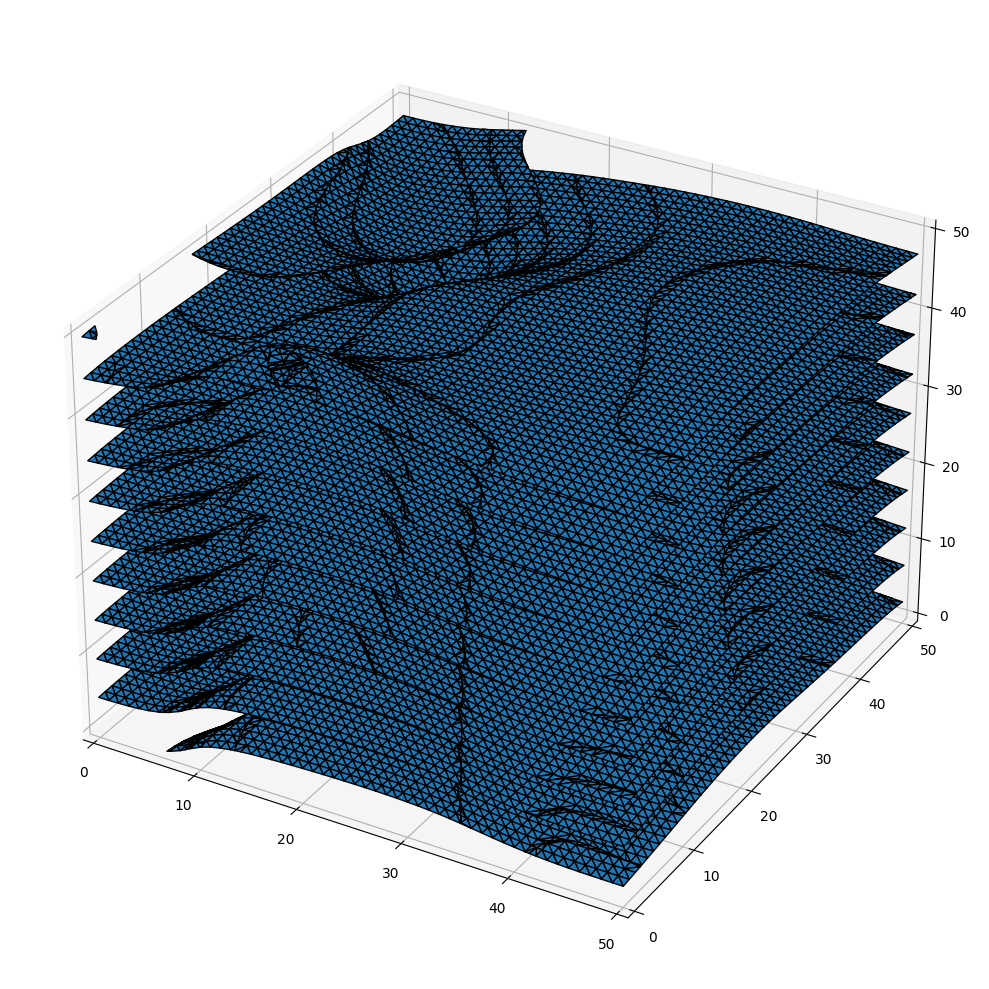

In [4]:
# %matplotlib widget
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlim(0, n_grid)
ax.set_ylim(0, n_grid)
ax.set_zlim(0, n_grid)

plt.tight_layout()
plt.show()

## Calculate scattering function according to mesh vertices

In [5]:
import time
import numexpr as ne
n_grid_q = 50
q_max = 2*np.pi/(2/n_grid)
q = np.linspace(-1,1,n_grid+1)*q_max
q_grid = np.meshgrid(q,q,q)
q_grid_flat = np.array([q_grid[0].flatten(),q_grid[1].flatten(),q_grid[2].flatten()])
r = verts / n_grid * 2

# # sum over exp(iq.r)
# start_time = time.time()
# q_dot_r_start_time = time.time()
# q_dot_r = r @ q_grid_flat
# q_dot_r_end_time = time.time()

# exp_i_q_dot_r_start_time = time.time()
# exp_i_q_dot_r = ne.evaluate("exp(1j * q_dot_r)")
# exp_i_q_dot_r_end_time = time.time()

# F_q_start_time = time.time()
# F_q = np.sum(exp_i_q_dot_r, axis=0)
# F_q_end_time = time.time()

# I_q = np.abs(F_q) ** 2
# end_time = time.time()

# print(f"Time taken for q dot r: {q_dot_r_end_time - q_dot_r_start_time} seconds")
# print(f"Time taken for exp(iq.r): {exp_i_q_dot_r_end_time - exp_i_q_dot_r_start_time} seconds")
# print(f"Time taken for sum: {F_q_end_time - F_q_start_time} seconds")
# print(f"Total time taken for computation: {end_time - start_time} seconds")

def calculate_I_q(q_grid, r):
    q_grid_flat = np.array([q_grid[0].flatten(), q_grid[1].flatten(), q_grid[2].flatten()])

    # sum over exp(iq.r)
    start_time = time.time()
    
    q_dot_r_start_time = time.time()
    q_dot_r = r @ q_grid_flat
    q_dot_r_end_time = time.time()
    
    exp_i_q_dot_r_start_time = time.time()
    exp_i_q_dot_r = ne.evaluate("exp(1j * q_dot_r)")
    exp_i_q_dot_r_end_time = time.time()
    
    F_q_start_time = time.time()
    F_q = np.sum(exp_i_q_dot_r, axis=0)
    F_q_end_time = time.time()
    
    I_q = np.abs(F_q) ** 2
    end_time = time.time()
    
    print(f"Time taken for q dot r: {q_dot_r_end_time - q_dot_r_start_time} seconds")
    print(f"Time taken for exp(iq.r): {exp_i_q_dot_r_end_time - exp_i_q_dot_r_start_time} seconds")
    print(f"Time taken for sum: {F_q_end_time - F_q_start_time} seconds")

    print(f"Total time taken for computation: {end_time - start_time} seconds")
    return I_q

I_q = calculate_I_q(q_grid, r)

Time taken for q dot r: 4.019298791885376 seconds
Time taken for exp(iq.r): 8.665076494216919 seconds
Time taken for sum: 3.14481782913208 seconds
Total time taken for computation: 15.831779956817627 seconds


In [6]:
qq = np.linspace(0,q_max,int(n_grid_q/2))
# q_radius = np.linalg.norm(q_grid_flat, axis=0)
# index_q = np.digitize(q_radius,qq)

# # Histogram binning of I_q
# I_qq = np.zeros_like(qq)
# for i in range(np.max(index_q)):
#     I_qq[i] = np.mean(I_q[index_q == i])
    
def calculate_I_qq(qq, q_grid, I_q):
    q_grid_flat = np.array([q_grid[0].flatten(), q_grid[1].flatten(), q_grid[2].flatten()])
    q_radius = np.linalg.norm(q_grid_flat, axis=0)
    index_q = np.digitize(q_radius,qq)
    I_qq = np.zeros_like(qq)
    for i in range(1, len(qq)):
        I_qq[i] = np.mean(I_q[index_q == i])
    return I_qq

I_qq = calculate_I_qq(qq, q_grid, I_q)

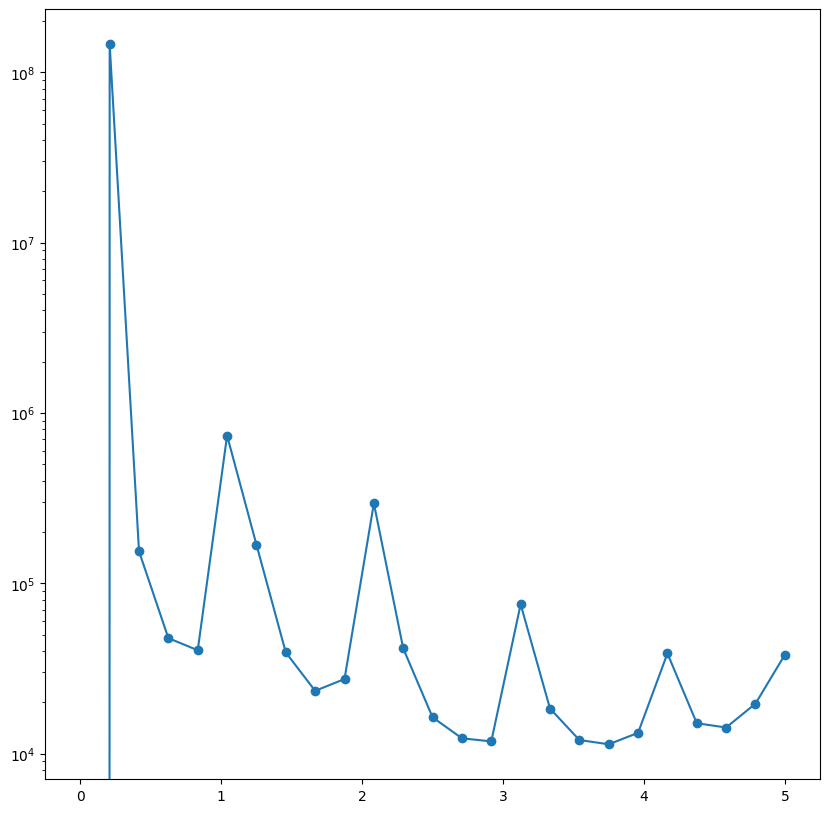

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.plot(qq*(1/scale)/np.pi/2, I_qq, 'o-')

ax.set_yscale('log')
# ax.set_xscale('log')

## Calculate scattering function of triangular mesh

In [27]:
import fast_simplification
grid = pv.StructuredGrid(r_grid[1], r_grid[0], r_grid[2])
grid["vol"] = rho.flatten('F')
mesh = grid.contour([0])
mesh_simp = fast_simplification.simplify_mesh(mesh, target_reduction=0.8)

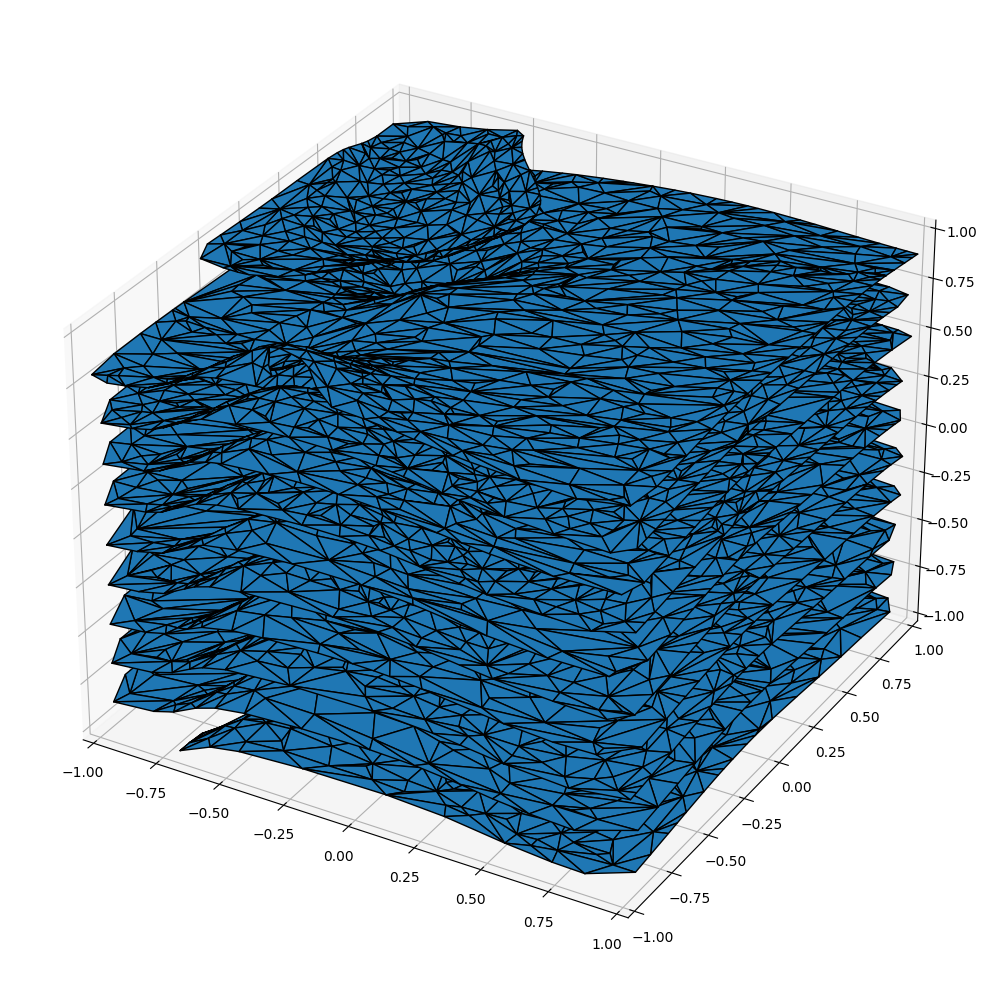

In [28]:
verts = mesh_simp.points
faces = mesh_simp.faces.reshape((-1, 4))[:, 1:]
normals = mesh_simp.point_normals

# %matplotlib widget
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
Poly3Dmesh = Poly3DCollection(verts[faces])
Poly3Dmesh.set_edgecolor('k')
ax.add_collection3d(Poly3Dmesh)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

plt.tight_layout()
plt.show()

In [29]:
import time

def scattering_function(verts, faces, q_grid):
    """
    Evaluate the scattering function of the whole mesh over a grid of wave vectors.
    
    Parameters:
    vertices (numpy.ndarray): Array of shape (n, 3) containing the vertices of the mesh.
    faces (numpy.ndarray): Array of shape (m, 3) containing the indices of the vertices forming each face.
    q_grid (list): List of 3 numpy arrays representing the grid of wave vectors.
    
    Returns:
    numpy.ndarray: The scattering function values over the grid.
    """
    print("Flattening q_grid...")
    start_time = time.time()
    q_grid_flat = np.array([q_grid[0].flatten(), q_grid[1].flatten(), q_grid[2].flatten()])
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating triangle areas...")
    start_time = time.time()
    r1 = verts[faces[:, 0]]
    r2 = verts[faces[:, 1]]
    r3 = verts[faces[:, 2]]
    areas = 0.5 * np.linalg.norm(np.cross(r2 - r1, r3 - r1), axis=1)
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating q_dot_r for all vertices...")
    start_time = time.time()
    q_dot_r_all = verts @ q_grid_flat
    exp_i_q_dot_r_all = ne.evaluate("exp(1j * q_dot_r_all)")
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating q_dot_r for all faces...")
    start_time = time.time()
    q_dot_r_faces = q_dot_r_all[faces]
    exp_i_q_dot_r_faces0 = exp_i_q_dot_r_all[faces[:, 0], :]
    exp_i_q_dot_r_faces1 = exp_i_q_dot_r_all[faces[:, 1], :]
    exp_i_q_dot_r_faces2 = exp_i_q_dot_r_all[faces[:, 2], :]
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating (qr1 - qr2), (qr2 - qr3), (qr3 - qr1)...")
    start_time = time.time()
    qr1_minus_qr2 = q_dot_r_faces[:, 0, :] - q_dot_r_faces[:, 1, :]
    qr2_minus_qr3 = q_dot_r_faces[:, 1, :] - q_dot_r_faces[:, 2, :]
    qr3_minus_qr1 = q_dot_r_faces[:, 2, :] - q_dot_r_faces[:, 0, :]
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating term1, term2, term3...")
    start_time = time.time()
    term1 = ne.evaluate("exp_i_q_dot_r_faces2 * qr1_minus_qr2")
    term2 = ne.evaluate("exp_i_q_dot_r_faces0 * qr2_minus_qr3")
    term3 = ne.evaluate("exp_i_q_dot_r_faces1 * qr3_minus_qr1")
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating denominator...")
    start_time = time.time()
    denominator = qr1_minus_qr2 * qr2_minus_qr3 * qr3_minus_qr1
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating F_q...")
    start_time = time.time()
    areas_expanded = np.repeat(areas[:, np.newaxis], q_dot_r_faces.shape[2], axis=1)
    F_q_triangles = ne.evaluate("2 * areas_expanded * (term1 + term2 + term3) / denominator")
    F_q_triangles[denominator==0] = 0
    F_q = np.sum(F_q_triangles, axis=0)
    print(f"Time taken: {time.time() - start_time} seconds")

    print("Calculating scattering function I_q...")
    start_time = time.time()
    I_q = np.abs(F_q) ** 2
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Scattering function calculation complete.")
    return I_q


In [30]:
I_q2 = scattering_function(verts, faces, q_grid)
I_qq2 = calculate_I_qq(qq, q_grid, I_q2)

Flattening q_grid...
Time taken: 0.001371145248413086 seconds
Calculating triangle areas...
Time taken: 0.0013837814331054688 seconds
Calculating q_dot_r for all vertices...
Time taken: 2.471299409866333 seconds
Calculating q_dot_r for all faces...
Time taken: 12.198958396911621 seconds
Calculating (qr1 - qr2), (qr2 - qr3), (qr3 - qr1)...
Time taken: 4.746241807937622 seconds
Calculating term1, term2, term3...
Time taken: 1.9056494235992432 seconds
Calculating denominator...
Time taken: 3.2705533504486084 seconds
Calculating F_q...
Time taken: 8.47392201423645 seconds
Calculating scattering function I_q...
Time taken: 0.002432107925415039 seconds
Scattering function calculation complete.


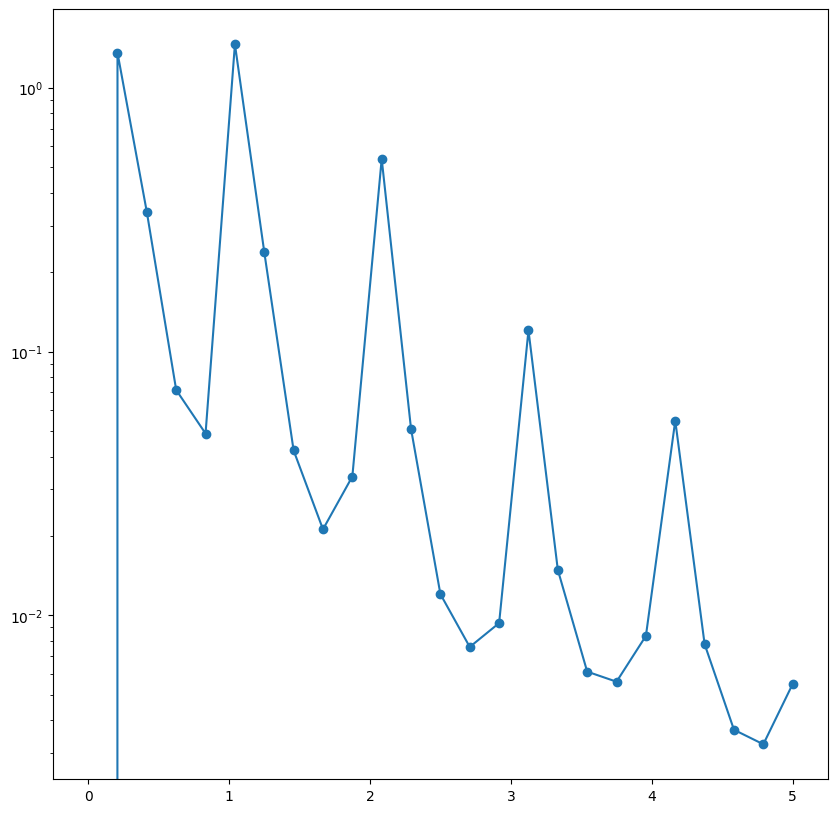

In [31]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.plot(qq*(1/scale)/np.pi/2, I_qq2, 'o-')

ax.set_yscale('log')
# ax.set_xscale('log')